## Cancer Dataset 

In here, I'm just playing around with data visualization and a cancer prediction model using a dataset from kaggle.

Link: https://www.kaggle.com/datasets/loveall/cervical-cancer-risk-classification

## Starting up the Dataset 

In [2]:
import pandas as pd 

cancerData = pd.read_csv('cancerDataset.csv')
cancerDataDup = cancerData.copy()
#Needed for the predictive model part 
cancerData = cancerData[cancerData.applymap(lambda x: isinstance(x, int))].dropna(axis = 1)

cancerData.head()

,Age,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,0,0,0,0,0,0,0,0,0
1,15,0,0,0,0,0,0,0,0,0
2,34,0,0,0,0,0,0,0,0,0
3,52,0,1,0,1,0,0,0,0,0
4,46,0,0,0,0,0,0,0,0,0


## Distribution Visualization 

<Figure size 800x600 with 0 Axes>

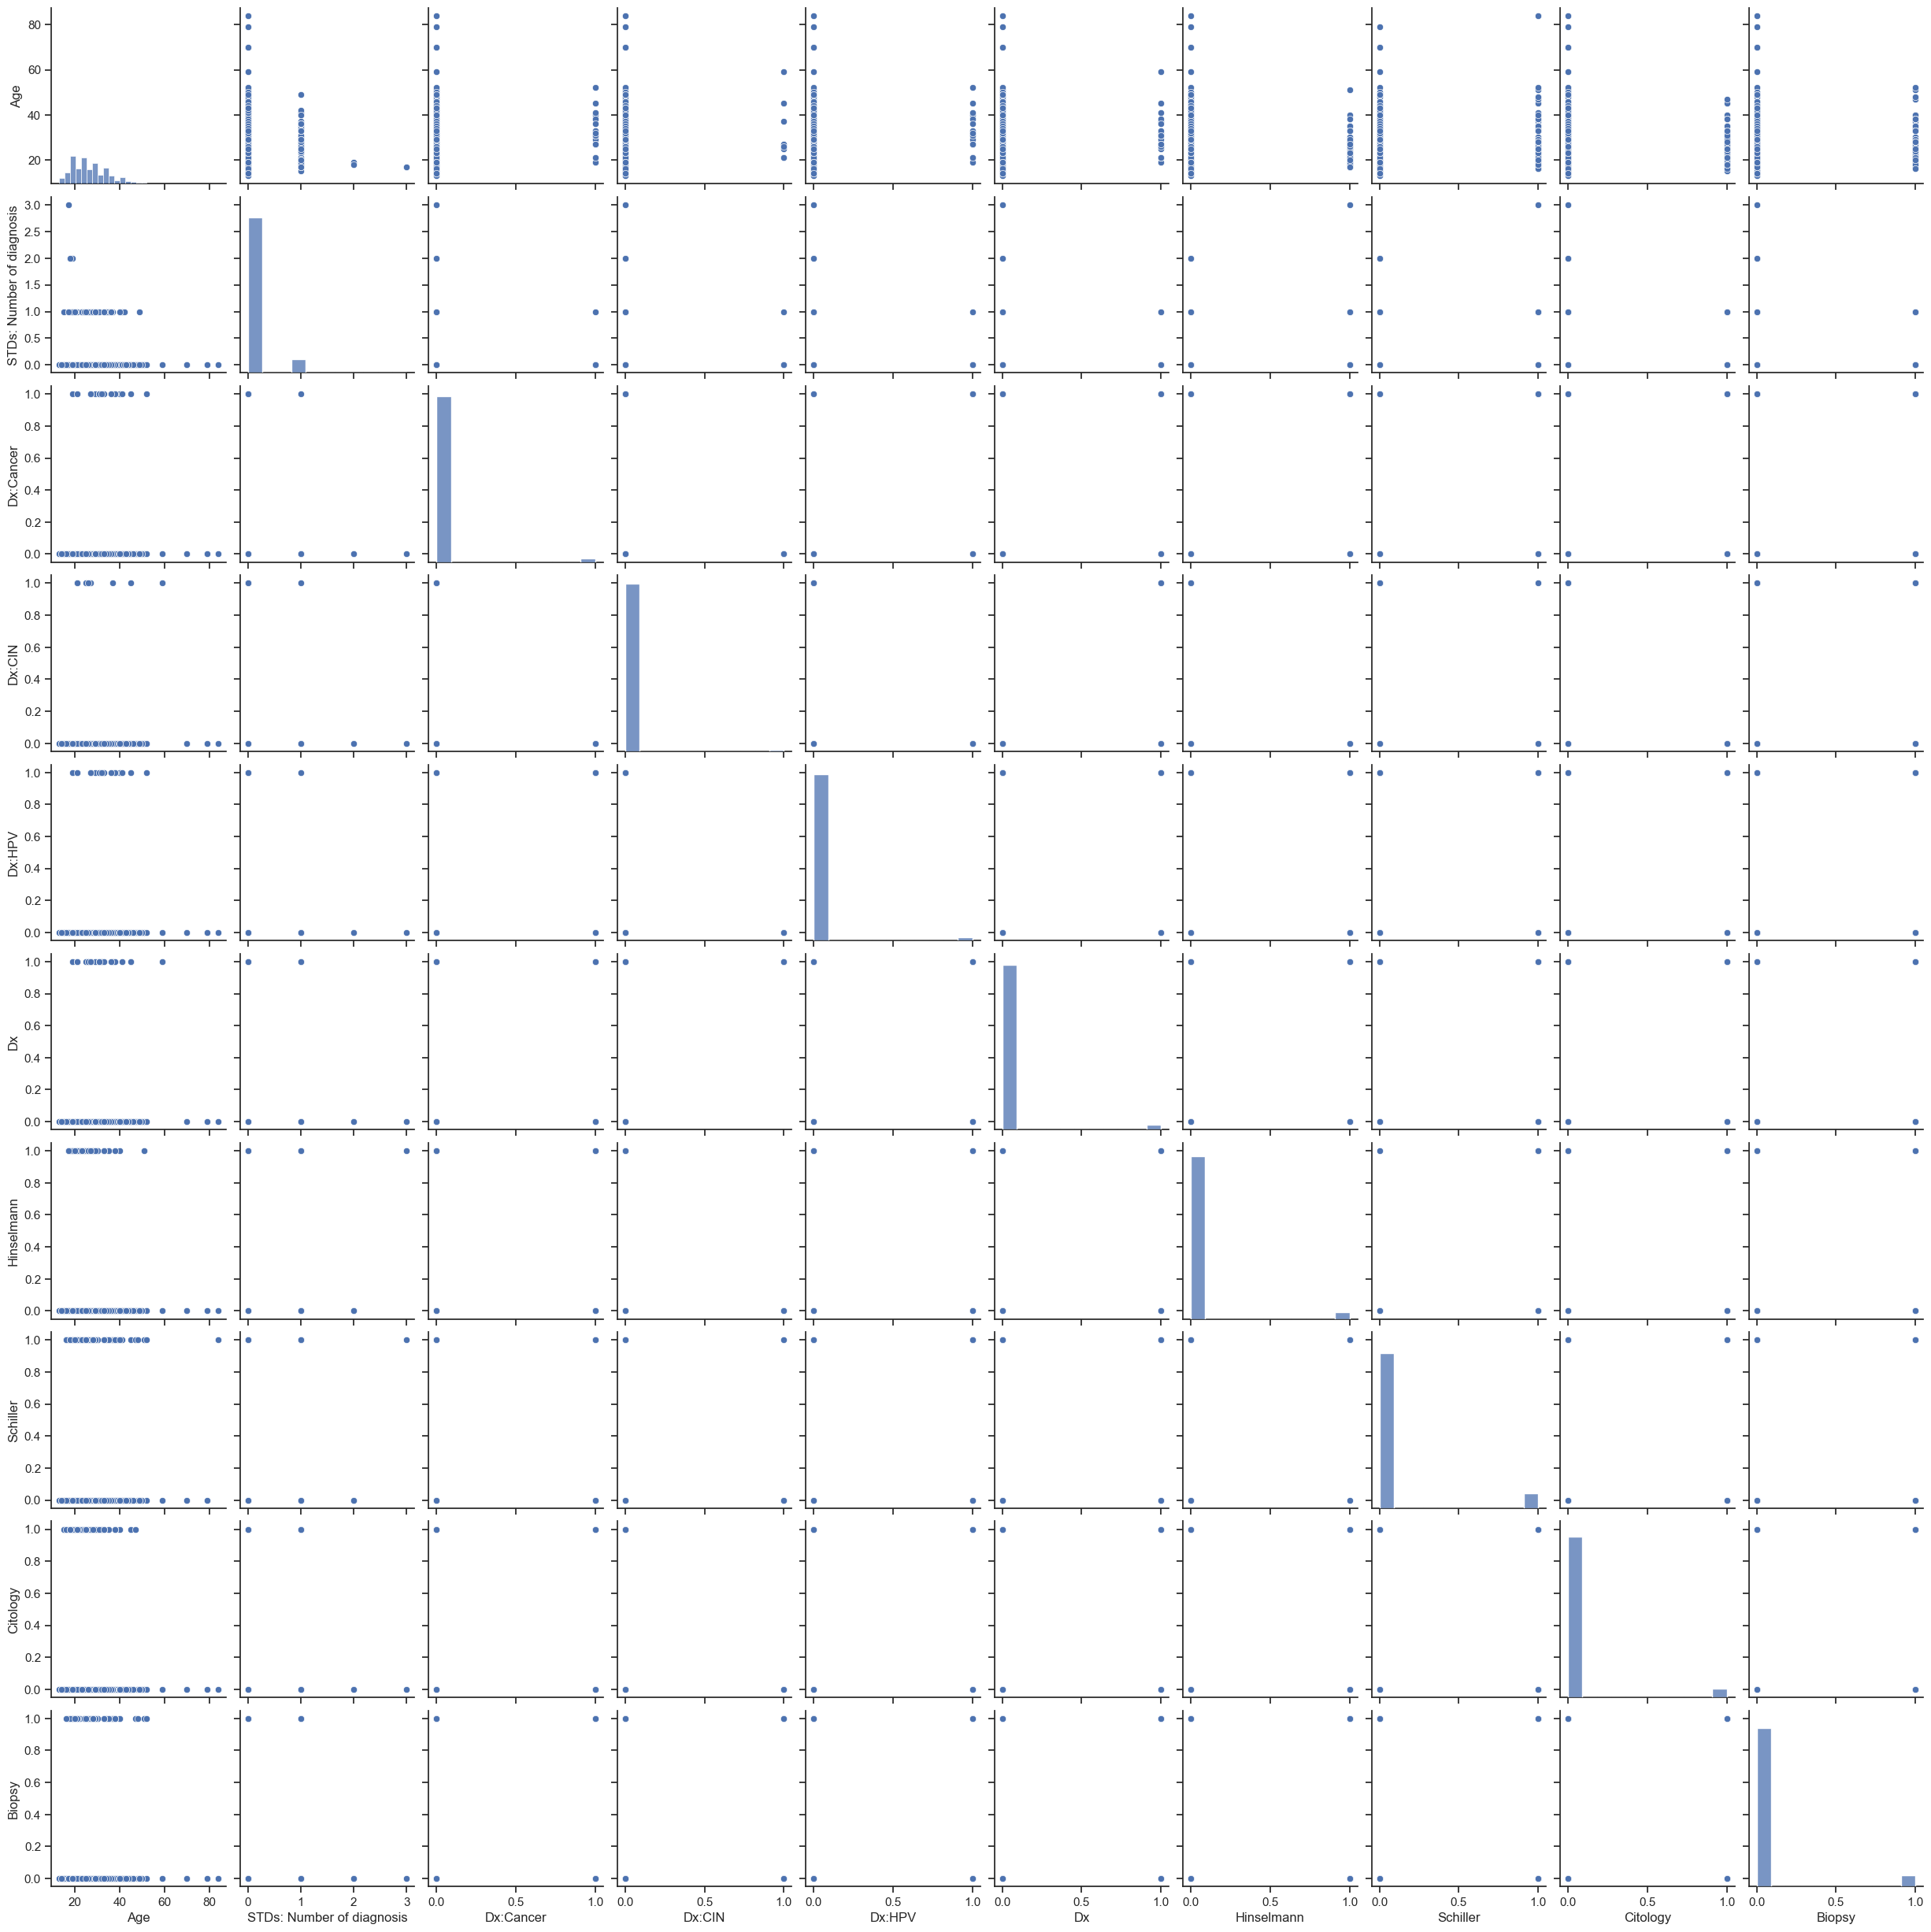

In [3]:
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style="ticks")
plt.figure(figsize=(8,6))
sns.pairplot(cancerData, diag_kind="hist")  # Use "hist" for histograms, "kde" for density plots
plt.show()

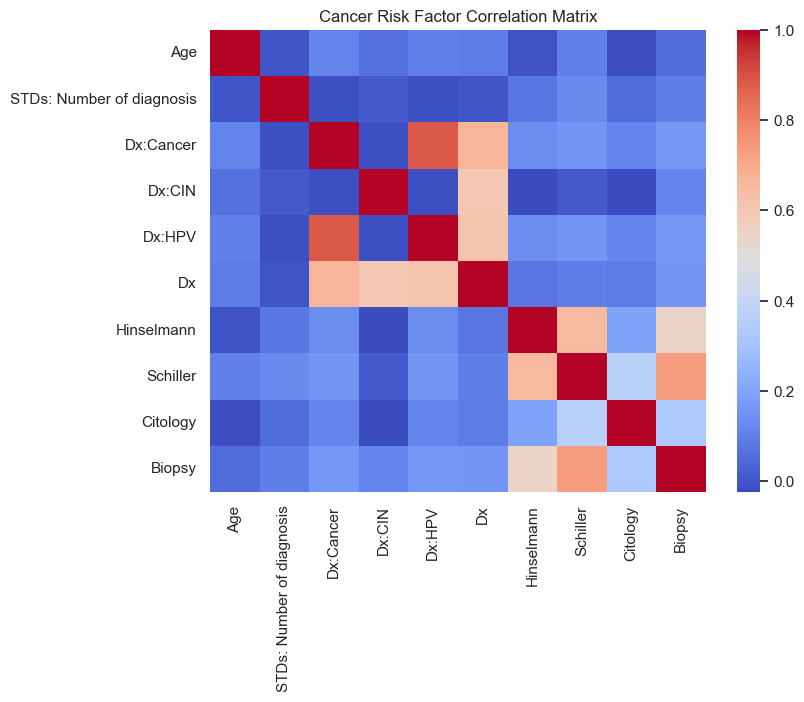

In [4]:
sns.set(style="white")
plt.figure(figsize=(8, 6))
sns.heatmap(cancerData.corr(), annot=False, cmap="coolwarm")
plt.title("Cancer Risk Factor Correlation Matrix")
plt.show()

## Making a predictive model 

Im going to make a comparison between using a DecisionTree or K-neighbors and see which does it better 

In [13]:
# Setting up the training and predicting data 

cancerDataDup = cancerDataDup.replace('?', 0).astype(float).fillna(cancerDataDup.mean(numeric_only = True))
testIndex = cancerDataDup.columns.get_loc('Dx:Cancer')
trainingDataFrame = cancerDataDup.iloc[:, : testIndex]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(trainingDataFrame)
y = cancerDataDup['Dx:Cancer']

# Splitting the data 

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

#Setting up a DecisionTree Model 

from sklearn.tree import DecisionTreeClassifier

decisionTree = DecisionTreeClassifier(criterion = "entropy", random_state = 2)

from sklearn.model_selection import cross_val_score

cross_val_score(decisionTree, X, y, cv = 5)
#Just testing the consistency of the random_state


array([0.95348837, 0.97093023, 0.97093023, 0.97660819, 0.98830409])

In [27]:
# Training the model 

decisionTree.fit(Xtrain, ytrain)

# Testing the model 

ypredict = decisionTree.predict(Xtest)

#Evaluate the results 

from sklearn.metrics import classification_report, confusion_matrix

print(np.mean(ypredict == ytest))
classification_report(ytest, ypredict)

#Accuracy seems legit 

0.9627906976744186


'              precision    recall  f1-score   support\n\n         0.0       0.98      0.99      0.98       210\n         1.0       0.00      0.00      0.00         5\n\n    accuracy                           0.96       215\n   macro avg       0.49      0.49      0.49       215\nweighted avg       0.95      0.96      0.96       215\n'

In [26]:
#Setting up the Knearest model 

from sklearn.neighbors import KNeighborsClassifier

kneighbor = KNeighborsClassifier(algorithm= 'ball_tree', n_neighbors = 10) # # of neighbors will have to be tested 

kneighbor.fit(Xtrain, ytrain)

ypredictK = kneighbor.predict(Xtest)

print(np.mean(ytest == ypredictK))
classification_report(ytest, ypredictK)

0.9767441860465116


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n         0.0       0.98      1.00      0.99       210\n         1.0       0.00      0.00      0.00         5\n\n    accuracy                           0.98       215\n   macro avg       0.49      0.50      0.49       215\nweighted avg       0.95      0.98      0.97       215\n'

## Seeing the Confusion Matrix 

This dataset is heavily biased to the 0 classification if you were to look at the distribution graphs, so I'm going to create a confusion matrix to make sure both are actually predicting the 1 classification 

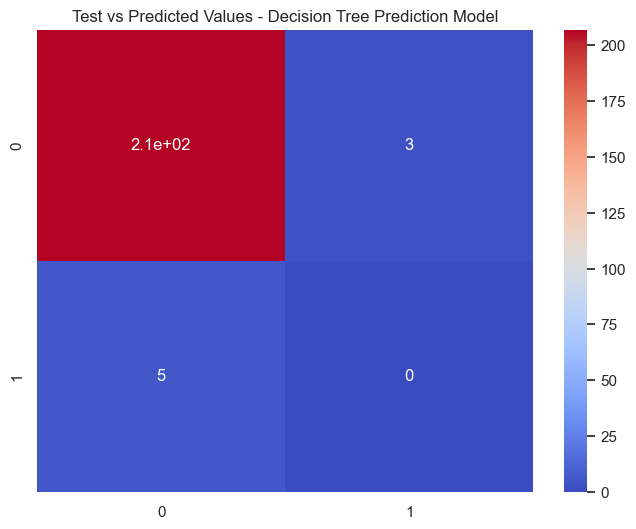

In [28]:
# Confusion matrix Decision Tree

sns.set(style="white")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(ytest, ypredict), annot=True, cmap="coolwarm")
plt.title("Test vs Predicted Values - Decision Tree Prediction Model")
plt.show()

#Welp, I was right to speculate 


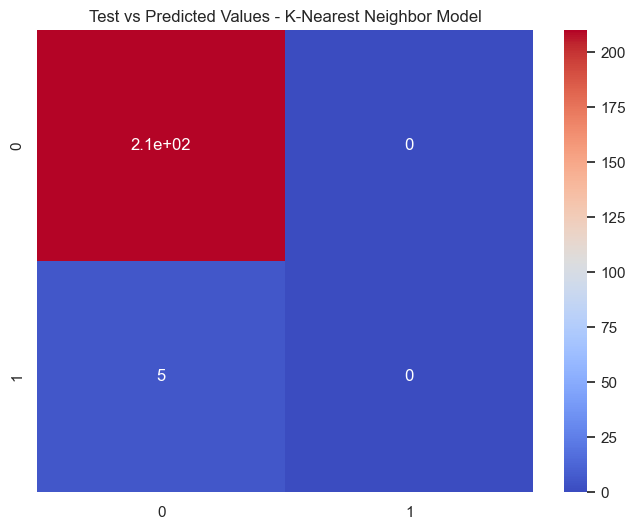

In [29]:
# Confusion matrix Knearest Neighbor 

sns.set(style="white")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(ytest, ypredictK), annot=True, cmap="coolwarm")
plt.title("Test vs Predicted Values - K-Nearest Neighbor Model")
plt.show()

#oh god 

## Modifying the dataset to be less biased 

You saw how infinitely bad and infinitely good it classifies the binary classification - something had to be done to address the overwhelming amount of 0s over 1s

In [40]:
len(cancerDataDup.loc[cancerDataDup['Dx:Cancer'] == 1])

#18 only.... its time to look for other classifications 


18

In [41]:
##Finding out which has the most for training 

bestCount = ['', 0]

for column in cancerDataDup.columns.tolist()[28:]:
    count = len(cancerDataDup.loc[cancerDataDup[column] == 1])

    if bestCount[1] < count:
        bestCount[0] = column
        bestCount[1] = count
    
bestCount

#Schiller it is 

['Schiller', 74]

In [62]:
#Partitioning the dataset to make it even in 1 and 0 classification 

classifiedOne = cancerDataDup.loc[cancerDataDup['Schiller'] == 1].reset_index(drop = True)
classifiedZero = cancerDataDup.loc[cancerDataDup['Schiller'] == 0].reset_index(drop = True)[:74]

unbiasedDataset = pd.concat([classifiedOne, classifiedZero], ignore_index= True).sample(frac = 1).reset_index(drop = True)

unbiasedDataset.head()


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,31.0,3.0,15.0,3.0,1.0,16.000000,0.8,0.0,0.00,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25.0,4.0,16.0,3.0,0.0,0.000000,0.0,1.0,1.00,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,21.0,3.0,14.0,3.0,0.0,0.000000,0.0,1.0,1.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,33.0,1.0,27.0,3.0,0.0,0.000000,0.0,1.0,0.16,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,44.0,3.0,15.0,0.0,1.0,1.266973,2.8,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
#Resetting the training data 

X = unbiasedDataset.iloc[:, :28]
y = unbiasedDataset['Schiller']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

#Retraining the models 

decisionTree.fit(Xtrain, ytrain)
kneighbor.fit(Xtrain, ytrain)

#prediction

ypredict = decisionTree.predict(Xtest)
ypredictK = kneighbor.predict(Xtest)

print('DecisionTree', cross_val_score(decisionTree, X, y, cv = 5))
print('Kneighbor',  cross_val_score(kneighbor, X, y, cv = 5))

#While the results does look a LOT more normal, the great fluctuation in accuracy requires some adjustment to it

DecisionTree [0.8        0.83333333 0.6        0.68965517 0.62068966]
Kneighbor [0.9        0.7        0.66666667 0.75862069 0.72413793]


In [137]:
# for the decision tree, it is likely the randomness causing this, ill also include a maximum depth so it clearly doesn't overfit

decisionTree.random_state = None 
maximum_depth = 10
decisionTree.criterion = 'gini' #interestingly, entropy is the root for the major fluctuations
#This is likely due to gini index being much more penalizing to errors as it squares the loss rather than subtract it 
#This means entropy is much more broader in its branches 

decisionTree.fit(Xtrain, ytrain)
ypredict = decisionTree.predict(Xtest)

print('DecisionTree', cross_val_score(decisionTree, X, y, cv = 5))

print(np.mean(ypredict == ytest))

#After testing numerous times, the decision tree classifier doesn't seem to work that well judging from the accuracy. Thus, we're gonna try a random forest

DecisionTree [0.7        0.73333333 0.63333333 0.5862069  0.5862069 ]
0.6486486486486487


In [168]:
#Setting up Random Forest 

from sklearn.ensemble import RandomForestClassifier


randomForest = RandomForestClassifier(random_state=1000)
randomForest.fit(Xtrain, ytrain)
ypredict = randomForest.predict(Xtest)

print('RandomForest', cross_val_score(randomForest, X, y, cv = 5))

print(np.mean(ypredict == ytest))

#It provided more consistent results and has a higher average than the decision tree so we're switching to random forest

RandomForest [0.76666667 0.73333333 0.63333333 0.75862069 0.79310345]
0.7567567567567568


In [164]:
kneighbor.n_neighbors = 50
kneighbor.algorithm = 'brute'
kneighbor.weights = 'uniform'

kneighbor.fit(Xtrain, ytrain)
ypredictK = kneighbor.predict(Xtest)

print('Kneighbor',  cross_val_score(kneighbor, X, y, cv = 5))

print(np.mean(ypredictK == ytest))

#Increased the accuracy by a bit by making it look for more accurate neighbors over efficiency 

Kneighbor [0.93333333 0.73333333 0.7        0.68965517 0.75862069]
0.7567567567567568


## Confusion Matrix of the fine-tuned models 

Admittingly, it is a little bizarre that their accuracy is the same, but the matrix should look a lot more normal.

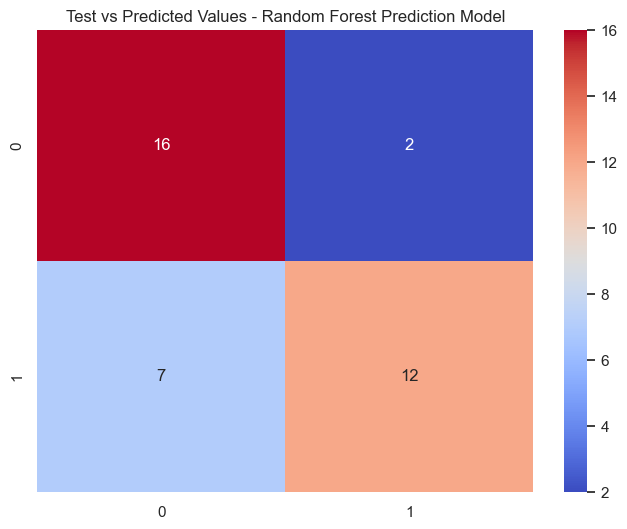

In [172]:
# Confusion matrix Decision Tree

sns.set(style="white")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(ytest, ypredict), annot=True, cmap="coolwarm")
plt.title("Test vs Predicted Values - Random Forest Prediction Model")
plt.show()

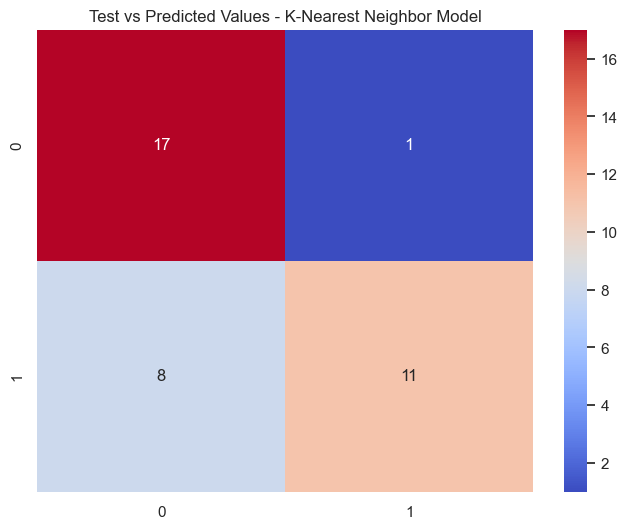

In [170]:
# Confusion matrix Knearest Neighbor 

sns.set(style="white")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(ytest, ypredictK), annot=True, cmap="coolwarm")
plt.title("Test vs Predicted Values - K-Nearest Neighbor Model")
plt.show()

Both provided almost the same results, so it doesn't matter which you use. Although, I feel the models could be fine tuned better, but a 75% accuracy is acceptable with the small dataset and rather basic machine learning algorithmn used. 